# Compute variance inflation factor (VIF) for 

Based on [Luke Chang's](https://dartbrains.org/content/GLM_Single_Subject_Model.html#variance-inflation-factor) guide

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator

In [76]:
data_dir = os.path.join('/bgfs/bchandrasekaran/krs228',
                        'data/FLT/data_denoised/')
layout = BIDSLayout(data_dir, derivatives=False)

In [77]:
subject = 'FLT28'

In [78]:
layout

BIDS Layout: .../krs228/data/FLT/data_denoised | Subjects: 27 | Sessions: 0 | Runs: 193

In [79]:
layout.get_tr(task='tonecat')

3.0

In [80]:
layout.get(subject=subject, task='tonecat', suffix='bold')

[<BIDSJSONFile filename='/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/sub-FLT28/func/sub-FLT28_task-tonecat_run-01_bold.json'>,
 <BIDSImageFile filename='/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/sub-FLT28/func/sub-FLT28_task-tonecat_run-01_bold.nii.gz'>,
 <BIDSJSONFile filename='/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/sub-FLT28/func/sub-FLT28_task-tonecat_run-06_bold.json'>,
 <BIDSImageFile filename='/bgfs/bchandrasekaran/krs228/data/FLT/data_denoised/sub-FLT28/func/sub-FLT28_task-tonecat_run-06_bold.nii.gz'>]

In [81]:
def load_bids_events(layout, subject):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = layout.get_tr( task='tonecat', )
    n_tr = nib.load(layout.get(subject=subject,  task='tonecat', scope='raw', extension='nii.gz')[-1].path).shape[-1]

    onsets = pd.read_csv(layout.get(subject=subject, task='tonecat', suffix='events')[0].path, sep='\t')
    onsets.drop(['Unnamed: 0', 'stim_file', 'response_time', 'correct_key'], axis='columns', inplace=True)
    onsets.rename(columns={'onset': 'Onset', 'duration': 'Duration', 'trial_type': 'Stim'}, inplace=True)
    onsets.dropna(inplace=True)
    #onsets.columns = ['Onset', 'Duration', 'Stim']
    return onsets_to_dm(onsets, sampling_freq=1/tr, run_length=n_tr)

dm = load_bids_events(layout, subject)

In [82]:
dm

,sound_di4-iN,resp_7,fb_wrong,sound_di1-hN,fb_noresp,sound_di3-aN,sound_di2-bN,sound_di3-iN,resp_6,sound_di1-bN,...,sound_di4-aN,resp_2,fb_correct,sound_di4-bN,sound_di2-aN,sound_di3-bN,sound_di3-hN,sound_di1-iN,sound_di4-hN,sound_di2-hN
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
dm = dm.reindex(sorted(dm.columns), axis=1)


In [84]:
dm.info()

<class 'nltools.data.design_matrix.Design_Matrix'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   fb_correct    126 non-null    float64
 1   fb_noresp     126 non-null    float64
 2   fb_wrong      126 non-null    float64
 3   resp_1        126 non-null    float64
 4   resp_2        126 non-null    float64
 5   resp_6        126 non-null    float64
 6   resp_7        126 non-null    float64
 7   resp_8        126 non-null    float64
 8   sound_di1-aN  126 non-null    float64
 9   sound_di1-bN  126 non-null    float64
 10  sound_di1-hN  126 non-null    float64
 11  sound_di1-iN  126 non-null    float64
 12  sound_di2-aN  126 non-null    float64
 13  sound_di2-bN  126 non-null    float64
 14  sound_di2-hN  126 non-null    float64
 15  sound_di2-iN  126 non-null    float64
 16  sound_di3-aN  126 non-null    float64
 17  sound_di3-bN  126 non-null    float64
 18  sound_di3-hN  126

In [85]:
dm.head()

,fb_correct,fb_noresp,fb_wrong,resp_1,resp_2,resp_6,resp_7,resp_8,sound_di1-aN,sound_di1-bN,...,sound_di2-hN,sound_di2-iN,sound_di3-aN,sound_di3-bN,sound_di3-hN,sound_di3-iN,sound_di4-aN,sound_di4-bN,sound_di4-hN,sound_di4-iN
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot: >

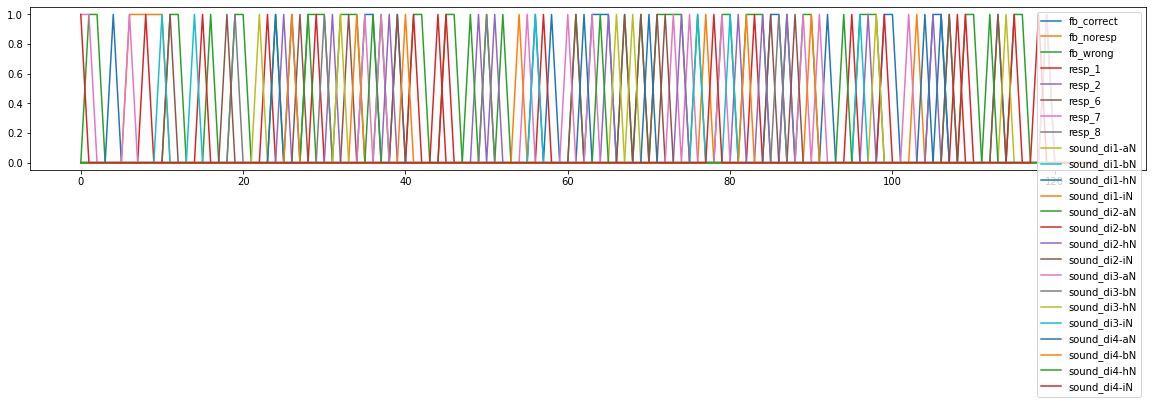

In [86]:
f,a = plt.subplots(figsize=(20,3))
dm.plot(ax=a)

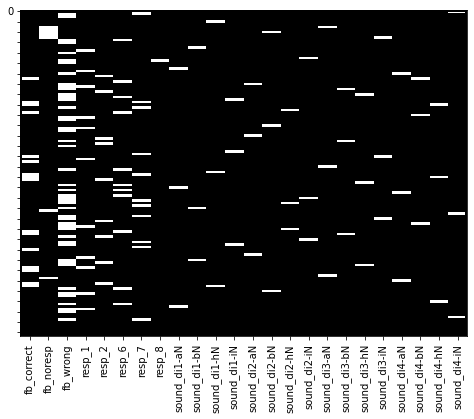

In [87]:
dm.heatmap()

In [88]:
dm.convolve?

Signature: dm.convolve(conv_func='hrf', columns=None)
Docstring:
Perform convolution using an arbitrary function.

Args:
    conv_func (ndarray or string): either a 1d numpy array containing output of a function that you want to convolve; a samples by kernel 2d array of several kernels to convolve; or the string 'hrf' which defaults to a glover HRF function at the Design_matrix's sampling_freq
    columns (list): what columns to perform convolution on; defaults
                    to all non-polynomial columns
File:      /bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nltools/data/design_matrix.py
Type:      method


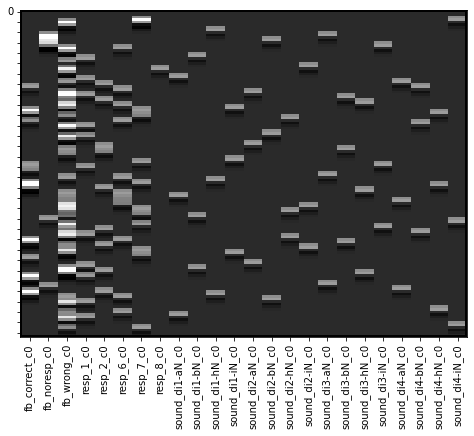

In [89]:
dm_conv = dm.convolve()
dm_conv.heatmap()

<AxesSubplot: >

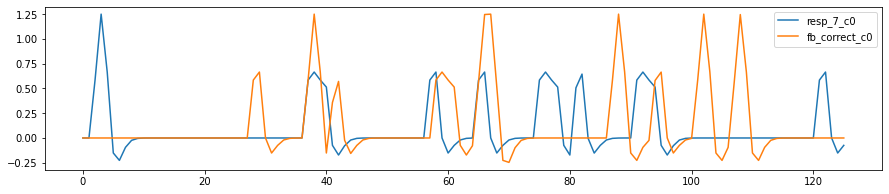

In [124]:
f,a = plt.subplots(figsize=(15,3))
dm_conv[['resp_7_c0','fb_correct_c0']].plot(ax=a)

max value: 0.38801982250453176


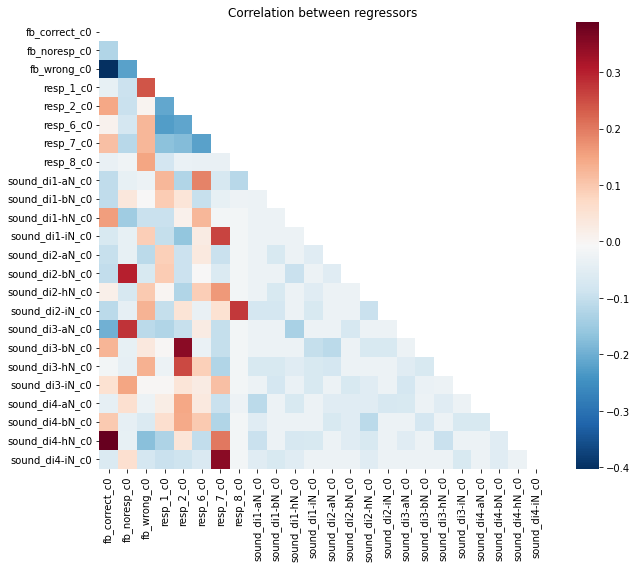

In [126]:

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(dm_conv.corr(), dtype=bool))

vmin = np.triu(dm_conv.corr(), k=1).min()
vmax = np.triu(dm_conv.corr(), k=1).max()
print('max value:', vmax)

f,a = plt.subplots(figsize=(10,8))
sns.heatmap(dm_conv.corr(), mask=mask, 
            vmin=vmin, vmax=vmax, 
            cmap='RdBu_r', ax=a, square=True)
plt.title('Correlation between regressors')
#plt.xticks(rotation=90);
#plt.yticks(rotation=45, ha='center');
f.tight_layout()


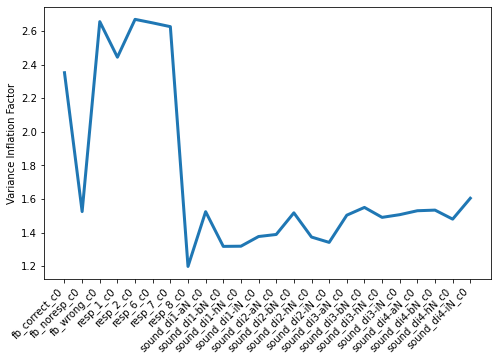

In [123]:
f,a = plt.subplots(figsize=(8,5))
a.plot(dm_conv.columns, dm_conv.vif(), linewidth=3)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Variance Inflation Factor');